## ツリー系

In [157]:
import pandas as pd
import numpy as np

import pickle
import json
import xgboost as xgb

import matplotlib.pyplot as plt
import japanize_matplotlib

In [158]:
test_df = pd.read_csv('../output/中間データ/評価用データ/test_preprocessed.csv')
test_df.head()

,generation_biomass,generation_fossil_gas,generation_fossil_hard_coal,generation_fossil_oil,generation_hydro_run_of_river_and_poundage,generation_hydro_water_reservoir,generation_nuclear,generation_other_renewable,generation_solar,generation_wind_onshore,...,gene_sum_scaled,total_load_actual_exp_mean_to_t,total_load_actual_exp_std_to_t,total_load_actual_scaled,weighted_wind_speed,weighted_temp,weighted_pressure,weighted_dew_point,weighted_clouds_all,encoded_price_weekday_hour
0,279.0,3927.0,895.0,189.0,1069.0,1893.0,7104.0,80.0,34.0,7398.0,...,-1.052525,28580.438356,4550.881691,-0.950022,4.847051,283.924904,1024.633059,278.223156,2.277092,58.414167
1,282.0,3948.0,878.0,177.0,1058.0,1024.0,7101.0,78.0,17.0,7342.0,...,-1.276847,28580.273848,4550.873250,-1.400451,3.125514,283.240165,1024.772291,276.051460,0.521262,50.789231
2,283.0,3791.0,890.0,175.0,1052.0,888.0,7100.0,78.0,9.0,7344.0,...,-1.345512,28580.031352,4550.956467,-1.709757,5.080933,283.257579,1025.224966,276.394731,0.000000,47.007692
3,280.0,3671.0,881.0,175.0,1032.0,645.0,7101.0,79.0,9.0,7668.0,...,-1.361516,28579.735304,4551.122963,-1.902549,4.751715,282.476523,1025.641975,278.573088,0.000000,44.716154
4,286.0,3460.0,861.0,173.0,1001.0,661.0,7101.0,79.0,8.0,7910.0,...,-1.361675,28579.405874,4551.349748,-1.982798,5.123457,281.531255,1026.094650,276.006937,7.818930,43.612308


In [159]:
fe_cols = [
    # 'price_actual', 
    'generation_biomass', 'generation_fossil_gas',
    'generation_fossil_hard_coal', 'generation_fossil_oil',
    'generation_hydro_run_of_river_and_poundage',
    'generation_hydro_water_reservoir', 'generation_nuclear',
    'generation_other_renewable', 'generation_solar', 'generation_wind_onshore', 
    # 'total_load_actual', 'time', 'gene_sum',
    'gene_load_ratio', 'residual_demand', 
    # 'residual_demand_ratio',
    'high_cost_ratio', 'tight_supply_flag', 
    # 'hour', 'weekday', 'month', 'quarter', 
    'dayofyear', 
    'gene_sum_exp_mean_to_t', 'gene_sum_exp_std_to_t', 'gene_sum_scaled',
    'total_load_actual_exp_mean_to_t', 'total_load_actual_exp_std_to_t', 'total_load_actual_scaled',
    'weighted_wind_speed', 'weighted_temp', 'weighted_pressure', 'weighted_dew_point', 'weighted_clouds_all',
    'encoded_price_weekday_hour', 
    # 'outlier_flag', 
    # 'weight'
]

In [160]:
X_test = test_df[fe_cols]

In [161]:
with open('../output/モデル/lgb_model.pkl', 'rb') as f:
    loaded_model = pickle.load(f)
model = loaded_model['model']

y_pred_lgb = np.expm1(model.predict(X_test))

In [162]:
# # モデル読み込み
# with open('../output/モデル/xgb_model.pkl', 'rb') as f:
#     loaded_model = pickle.load(f)

# model = loaded_model['model']  # xgb.Booster型を想定

# # X_test を DMatrix に変換
# dtest = xgb.DMatrix(X_test)

# # 予測実行
# y_pred_xgb = np.expm1(model.predict(dtest))

In [163]:
# y_pred_ens = np.mean([y_pred_lgb, y_pred_xgb], axis=0)

#### 予測結果の出力

In [164]:
result_df = pd.read_csv('../input/提出用データ/sample_submit.csv', header=None)

/var/folders/sb/t91v_nzj05sbsfnhcjb832xr0000gn/T/ipykernel_65464/592907273.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[39.80176305 55.62342299 51.81287807 ... 69.0831113  61.25972108
 58.03287301]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  result_df.iloc[:, 1] = y_pred_lgb
/var/folders/sb/t91v_nzj05sbsfnhcjb832xr0000gn/T/ipykernel_65464/592907273.py:6: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  result_df.iloc[:, 0] = pd.to_datetime(result_df.iloc[:, 0])


                           0          1
0  2018-01-01 00:00:00+01:00  39.801763
1  2018-01-01 01:00:00+01:00  55.623423
2  2018-01-01 02:00:00+01:00  51.812878
3  2018-01-01 03:00:00+01:00  46.826604
4  2018-01-01 04:00:00+01:00  44.032360


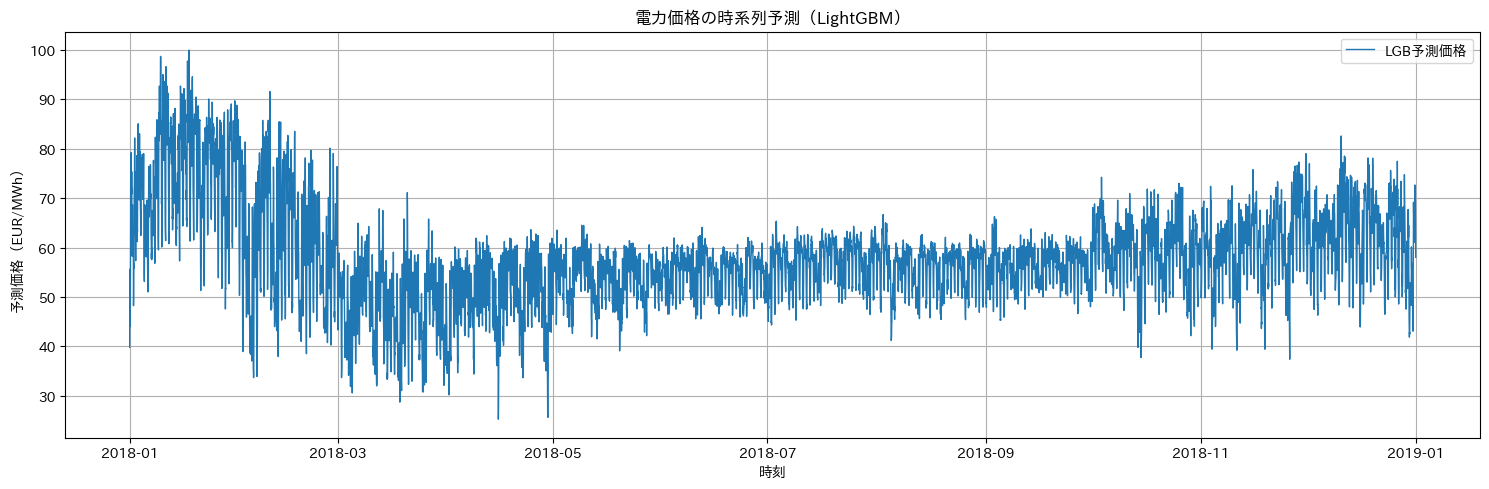

In [165]:
result_df.iloc[:, 1] = y_pred_lgb
result_df.to_csv('../output/予測結果/予測結果_lgb.csv', index=False)
print(result_df.head())

# time列をdatetime型に変換
result_df.iloc[:, 0] = pd.to_datetime(result_df.iloc[:, 0])

# プロット
plt.figure(figsize=(15, 5))
plt.plot(result_df.iloc[:, 0], result_df.iloc[:, 1], label='LGB予測価格', linewidth=1)

plt.xlabel('時刻')
plt.ylabel('予測価格（EUR/MWh）')
plt.title('電力価格の時系列予測（LightGBM）')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

                           0          1
0  2018-01-01 00:00:00+01:00  30.701633
1  2018-01-01 01:00:00+01:00  59.540295
2  2018-01-01 02:00:00+01:00  46.057236
3  2018-01-01 03:00:00+01:00  42.066784
4  2018-01-01 04:00:00+01:00  36.022648


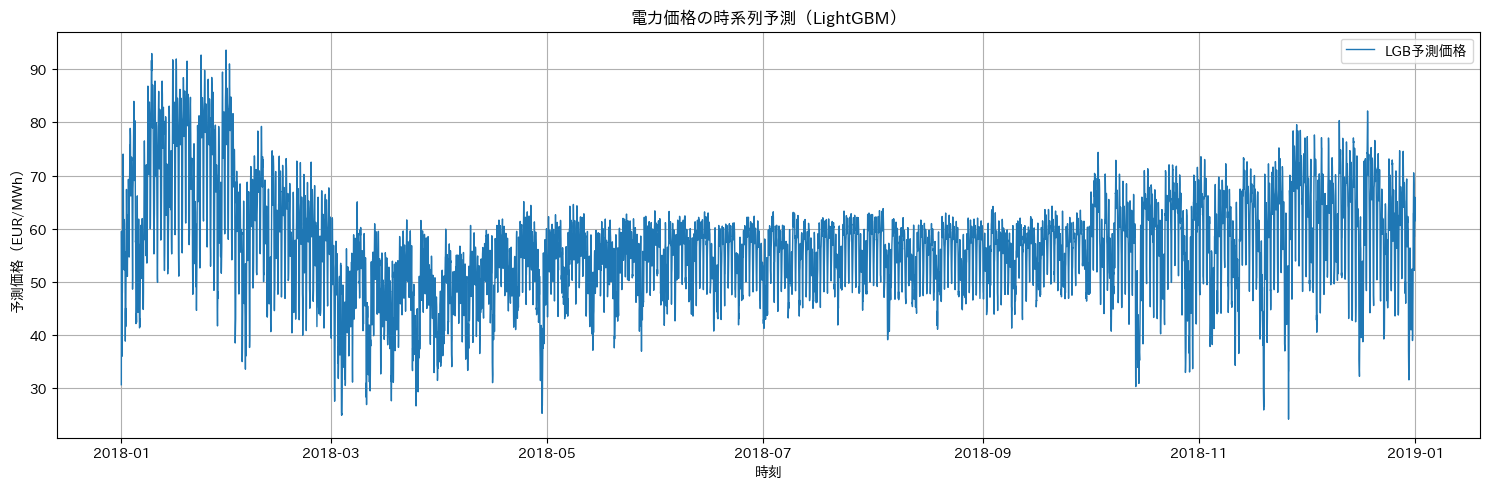

In [84]:
result_df.iloc[:, 1] = y_pred_xgb
result_df.to_csv('../output/予測結果/予測結果_xgb.csv', index=False)
print(result_df.head())

# プロット
plt.figure(figsize=(15, 5))
plt.plot(result_df.iloc[:, 0], result_df.iloc[:, 1], label='LGB予測価格', linewidth=1)

plt.xlabel('時刻')
plt.ylabel('予測価格（EUR/MWh）')
plt.title('電力価格の時系列予測（LightGBM）')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

                           0          1
0  2018-01-01 00:00:00+01:00  31.988998
1  2018-01-01 01:00:00+01:00  65.266934
2  2018-01-01 02:00:00+01:00  47.588035
3  2018-01-01 03:00:00+01:00  45.095301
4  2018-01-01 04:00:00+01:00  38.870103


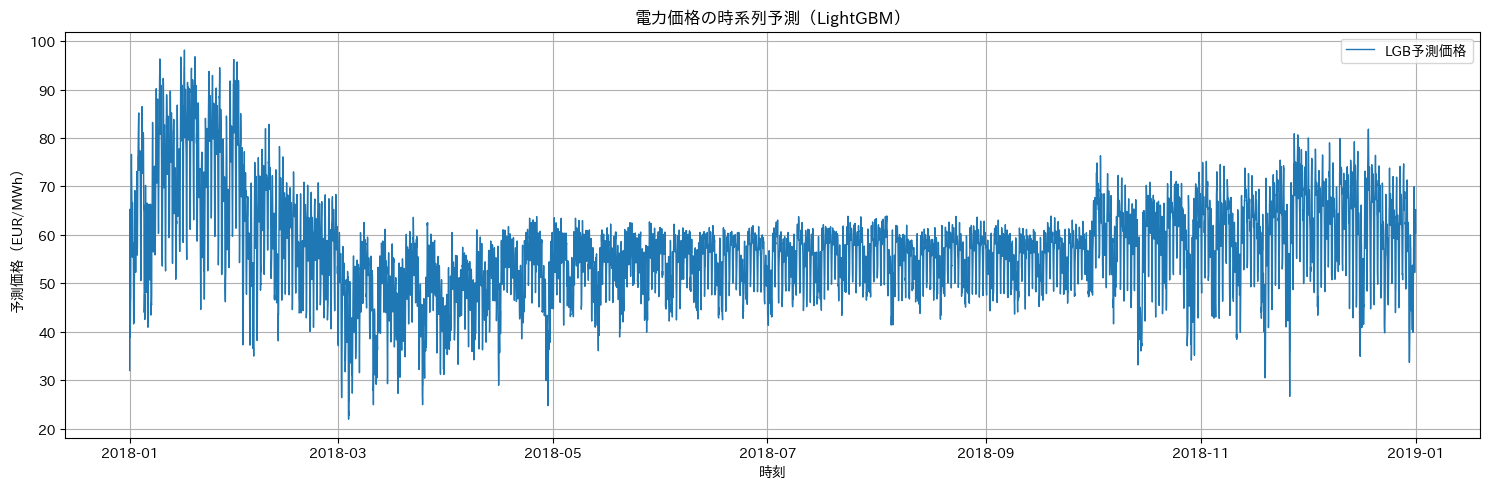

In [85]:
result_df.iloc[:, 1] = y_pred_ens
result_df.to_csv('../output/予測結果/予測結果_ens.csv', index=False)
print(result_df.head())

# プロット
plt.figure(figsize=(15, 5))
plt.plot(result_df.iloc[:, 0], result_df.iloc[:, 1], label='LGB予測価格', linewidth=1)

plt.xlabel('時刻')
plt.ylabel('予測価格（EUR/MWh）')
plt.title('電力価格の時系列予測（LightGBM）')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## LSTM

#### 24時間前

In [59]:
test_features_for_lstm24_df = pd.read_csv('../output/中間データ/評価用データ/test_features_for_lstm24.csv')

In [60]:
from tensorflow.keras.models import load_model

# モデル本体
lesm_model24 = load_model('../output/モデル/lstm_model24.keras')

In [61]:
SEQ_LEN = 24

X_test = []
for i in range(len(test_features_for_lstm24_df) - SEQ_LEN):
    X_test.append(test_features_for_lstm24_df[i:i+SEQ_LEN])
X_test = np.array(X_test)
y_pred_lstm24 = np.expm1(lesm_model24.predict(X_test)).flatten()

274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


                           0          1
0  2018-01-01 00:00:00+01:00  46.971241
1  2018-01-01 01:00:00+01:00  43.742661
2  2018-01-01 02:00:00+01:00  42.118279
3  2018-01-01 03:00:00+01:00  39.348621
4  2018-01-01 04:00:00+01:00  37.234364


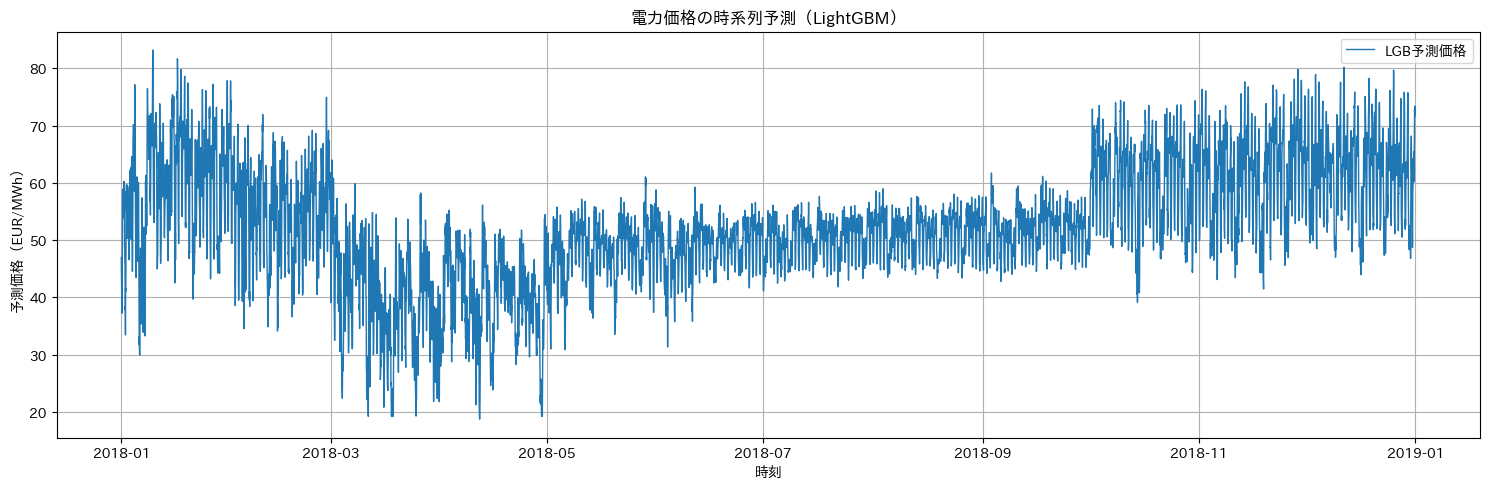

In [62]:
result_df.iloc[:, 1] = y_pred_lstm24
result_df.to_csv('../output/予測結果/予測結果_lstm24.csv', index=False)
print(result_df.head())

# プロット
plt.figure(figsize=(15, 5))
plt.plot(result_df.iloc[:, 0], result_df.iloc[:, 1], label='LGB予測価格', linewidth=1)

plt.xlabel('時刻')
plt.ylabel('予測価格（EUR/MWh）')
plt.title('電力価格の時系列予測（LightGBM）')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#### 1週間

In [63]:
# test_features_for_lstm168_df = pd.read_csv('../output/中間データ/評価用データ/test_features_for_lstm168.csv')

# # モデル本体
# lesm_model168 = load_model('../output/モデル/lstm_model168.keras')

# SEQ_LEN = 168

# X_test = []
# for i in range(len(test_features_for_lstm168_df) - SEQ_LEN):
#     X_test.append(test_features_for_lstm168_df[i:i+SEQ_LEN])
# X_test = np.array(X_test)
# y_pred_lstm168 = lesm_model168.predict(X_test).flatten()

In [64]:
y_pred_ens = np.mean([y_pred_xgb, y_pred_lstm24], axis=0)

                           0          1
0  2018-01-01 00:00:00+01:00  37.138786
1  2018-01-01 01:00:00+01:00  46.431515
2  2018-01-01 02:00:00+01:00  40.712708
3  2018-01-01 03:00:00+01:00  37.733864
4  2018-01-01 04:00:00+01:00  34.976398


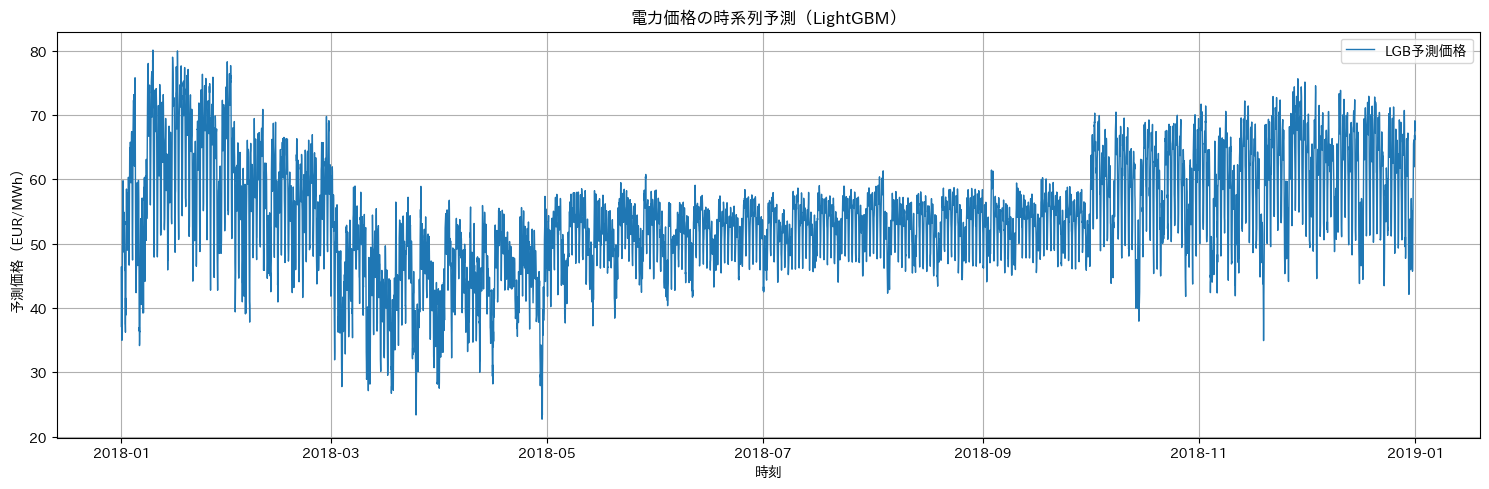

In [65]:
result_df.iloc[:, 1] = y_pred_ens
result_df.to_csv('../output/予測結果/予測結果_ens.csv', index=False)
print(result_df.head())

# プロット
plt.figure(figsize=(15, 5))
plt.plot(result_df.iloc[:, 0], result_df.iloc[:, 1], label='LGB予測価格', linewidth=1)

plt.xlabel('時刻')
plt.ylabel('予測価格（EUR/MWh）')
plt.title('電力価格の時系列予測（LightGBM）')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()